In [1]:
import itertools
import json
from pathlib import Path
import re
import sys
sys.path.append("../src")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

../src/util.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in sta

In [2]:
# Path to decoder results
decoder_path = Path("../models/decoders")

In [3]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
checkpoint_steps = list(range(5,255,5))
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [1, 2, 3, 4]

In [4]:
decoding_perfs = util.load_decoding_perfs(decoder_path, glob_prefix="encodings.")

In [5]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    
    m_target_runs = [-1] if model is None else target_runs
    for target_run in m_target_runs:
        target_run_str = "" if target_run == -1 else "-run%i" % target_run
        
        if model is None:
            model_dir = bert_path / bert_base_model
        else:
            # DEV
            model_dir = bert_path / ("%s.%s.%s%s" % (finetune_desc, bert_base_model, model, target_run_str))

        try:
            metadata = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        except: pass
        
        if metadata["steps"]:
            model_metadata[model, target_run] = pd.DataFrame.from_dict(metadata["steps"], orient="index")

model_metadata = pd.concat(model_metadata, names=["model", "run", "step"])

None


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Missing training events file in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
Missing eval events data in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
SQuAD
QQP
MNLI
SST


In [6]:
# SQuAD results need to be loaded separately from manual eval.
if "SQuAD" in bert_models:
    for target_run in target_runs:
        target_run_str = "" if target_run is None else "-run%i" % target_run
        model_dir = bert_path / ("%s.%s.SQuAD%s" % (finetune_desc, bert_base_model, target_run_str))

        for checkpoint_step in checkpoint_steps:
            pred_dir = model_dir / "predictions" / str(checkpoint_step)
            try:
                with (pred_dir / "results.json").open() as results_f:
                    results = json.load(results_f)
                model_metadata.loc["SQuAD", target_run, checkpoint_step]["eval_accuracy"] = \
                    results["best_f1"] / 100.
            except: pass

In [7]:
# Join into single df.
old_index = decoding_perfs.index
df = decoding_perfs.reset_index().join(model_metadata, on=["model", "run", "step"]).set_index(old_index.names)

-----------

In [8]:
all_subjects = df.index.get_level_values("subject").unique()
all_subjects

Index(['M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15', 'P01'], dtype='object', name='subject')

### Synthetic columns

In [9]:
df["eval_accuracy_delta"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda xs: xs - xs.iloc[0])
df["decoding_mse_delta"] = df.groupby(["model", "run", "subject"]).mse.transform(lambda xs: xs - xs.iloc[0])
df["eval_accuracy_norm"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda accs: (accs - accs.min()) / (accs.max() - accs.min()))

In [10]:
NUM_BINS = 50
df["eval_accuracy_bin"] = df.groupby(["model"]).eval_accuracy.transform(lambda xs: pd.cut(xs, np.linspace(xs.min(), xs.max(), NUM_BINS), labels=False))
df["decoding_mse_bin"] = df.groupby(["subject"]).decoding_mse_delta.transform(lambda xs: pd.cut(xs, np.linspace(xs.min(), xs.max(), NUM_BINS), labels=False))

In [11]:
ROLLING_WINDOW_SIZE = 5
grouped = df.groupby(["model", "run", "subject"])
for col in ["mse", "decoding_mse_delta", "eval_accuracy", "train_loss"]:
    df["%s_rolling" % col] = grouped[col].transform(lambda rows: rows.rolling(ROLLING_WINDOW_SIZE).mean())

In [12]:
df.tail()

mse        r2  total_global_norms  train_loss  \
model run step subject                                                       
SST   4   250  M08      0.003686 -0.063790          280.965663    0.136338   
               M09      0.003752 -0.059510          280.965663    0.136338   
               M14      0.003833 -0.015657          280.965663    0.136338   
               M15      0.003694 -0.057596          280.965663    0.136338   
               P01      0.003530 -0.048363          280.965663    0.136338   

                        train_loss_norm  eval_accuracy  eval_loss  \
model run step subject                                              
SST   4   250  M08             0.068169        0.90711   0.232592   
               M09             0.068169        0.90711   0.232592   
               M14             0.068169        0.90711   0.232592   
               M15             0.068169        0.90711   0.232592   
               P01             0.068169        0.90711   0.232592   

                        eval_accuracy_delta  decoding_mse_delta  \
model run step subject                                            
SST   4   250  M08                  0.36211            0.000050   
               M09                  0.36211            0.000055   
               M14                  0.36211            0.000092   
               M15                  0.36211            0.000117   
               P01                  0.36211            0.000073   

                        eval_accuracy_norm  eval_accuracy_bin  \
model run step subject                                          
SST   4   250  M08                0.998943               48.0   
               M09                0.998943               48.0   
               M14                0.998943               48.0   
               M15                0.998943               48.0   
               P01                0.998943               48.0   

                        decoding_mse_bin  mse_rolling  \
model run step subject                                  
SST   4   250  M08                  17.0     0.003697   
               M09                  20.0     0.003727   
               M14                  32.0     0.003834   
               M15                  25.0     0.003678   
               P01                  21.0     0.003529   

                        decoding_mse_delta_rolling  eval_accuracy_rolling  \
model run step subject                                                      
SST   4   250  M08                        0.000061               0.906422   
               M09                        0.000029               0.906422   
               M14                        0.000094               0.906422   
               M15                        0.000101               0.906422   
               P01                        0.000073               0.906422   

                        train_loss_rolling  
model run step subject                      
SST   4   250  M08                0.183471  
               M09                0.183471  
               M14                0.183471  
               M15                0.183471  
               P01                0.183471

In [13]:
dfi = df.reset_index()

## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


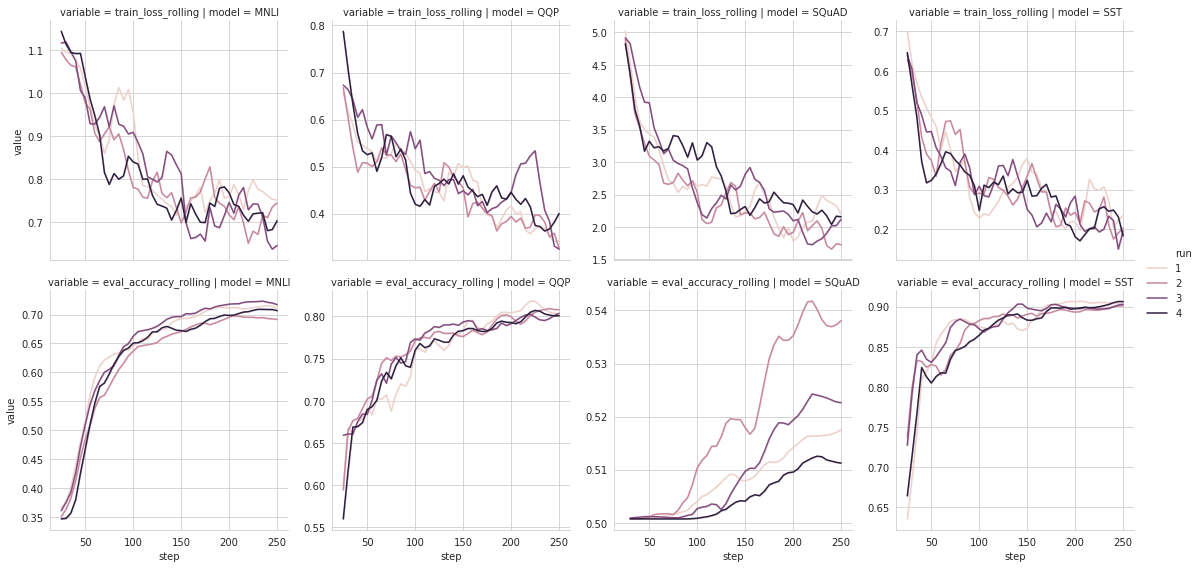

In [14]:
g = sns.FacetGrid(df.reset_index().melt(id_vars=["model", "run", "step"],
                                        value_vars=["train_loss_rolling", "eval_accuracy_rolling"]),
                  row="variable", col="model", sharex=True, sharey=False, height=4)
g.map(sns.lineplot, "step", "value", "run")
g.add_legend()

## Decoding analyses

In [15]:
MSE_DELTA_LABEL = "$\Delta$(MSE)"

### Step analysis

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


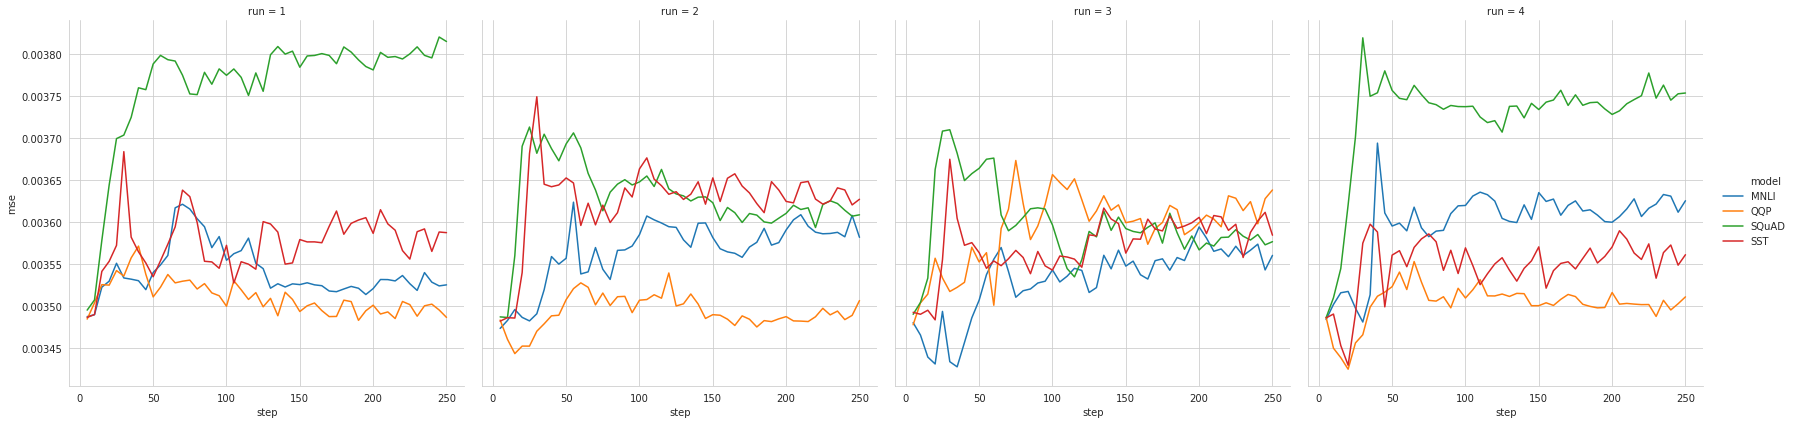

In [16]:
g = sns.FacetGrid(dfi[(dfi.subject == "M02")], col="run", size=6)
g.map(sns.lineplot, "step", "mse", "model").add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(1369.31,0.5,'$\\Delta$(MSE)')

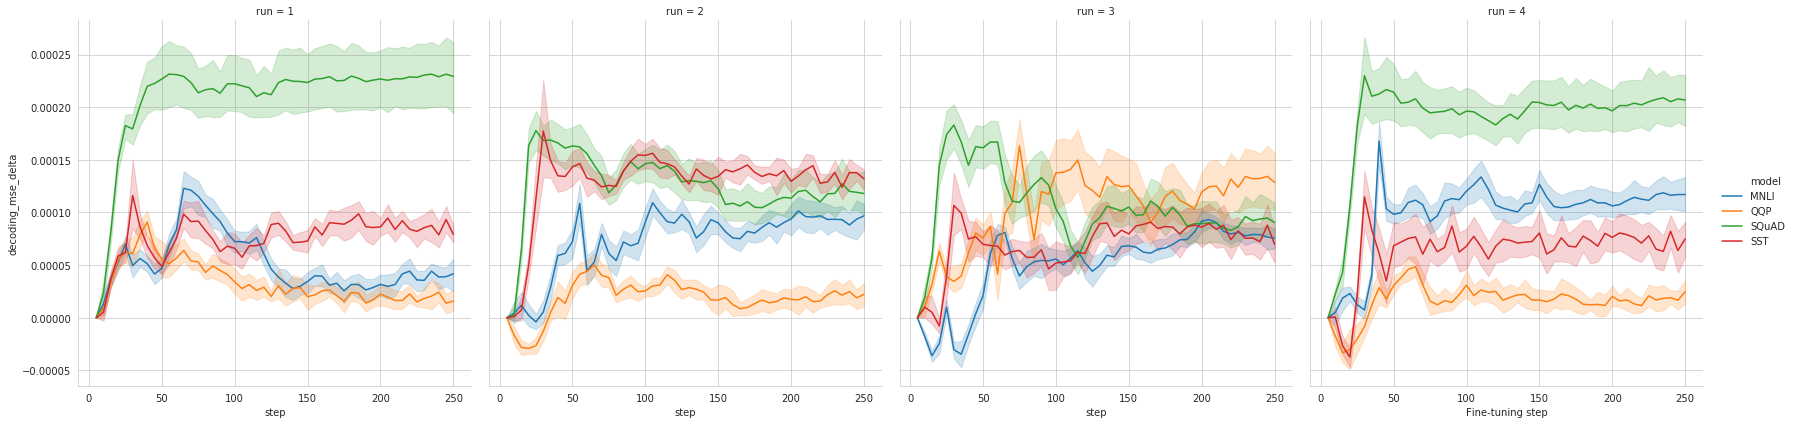

In [17]:
g = sns.FacetGrid(dfi, col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mse_delta", "model").add_legend()

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

Text(0,0.5,'$\\Delta$(MSE)')

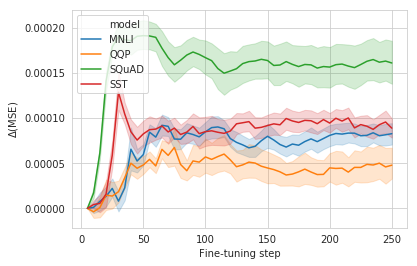

In [18]:
sns.lineplot(data=dfi, x="step", y="decoding_mse_delta", hue="model")

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


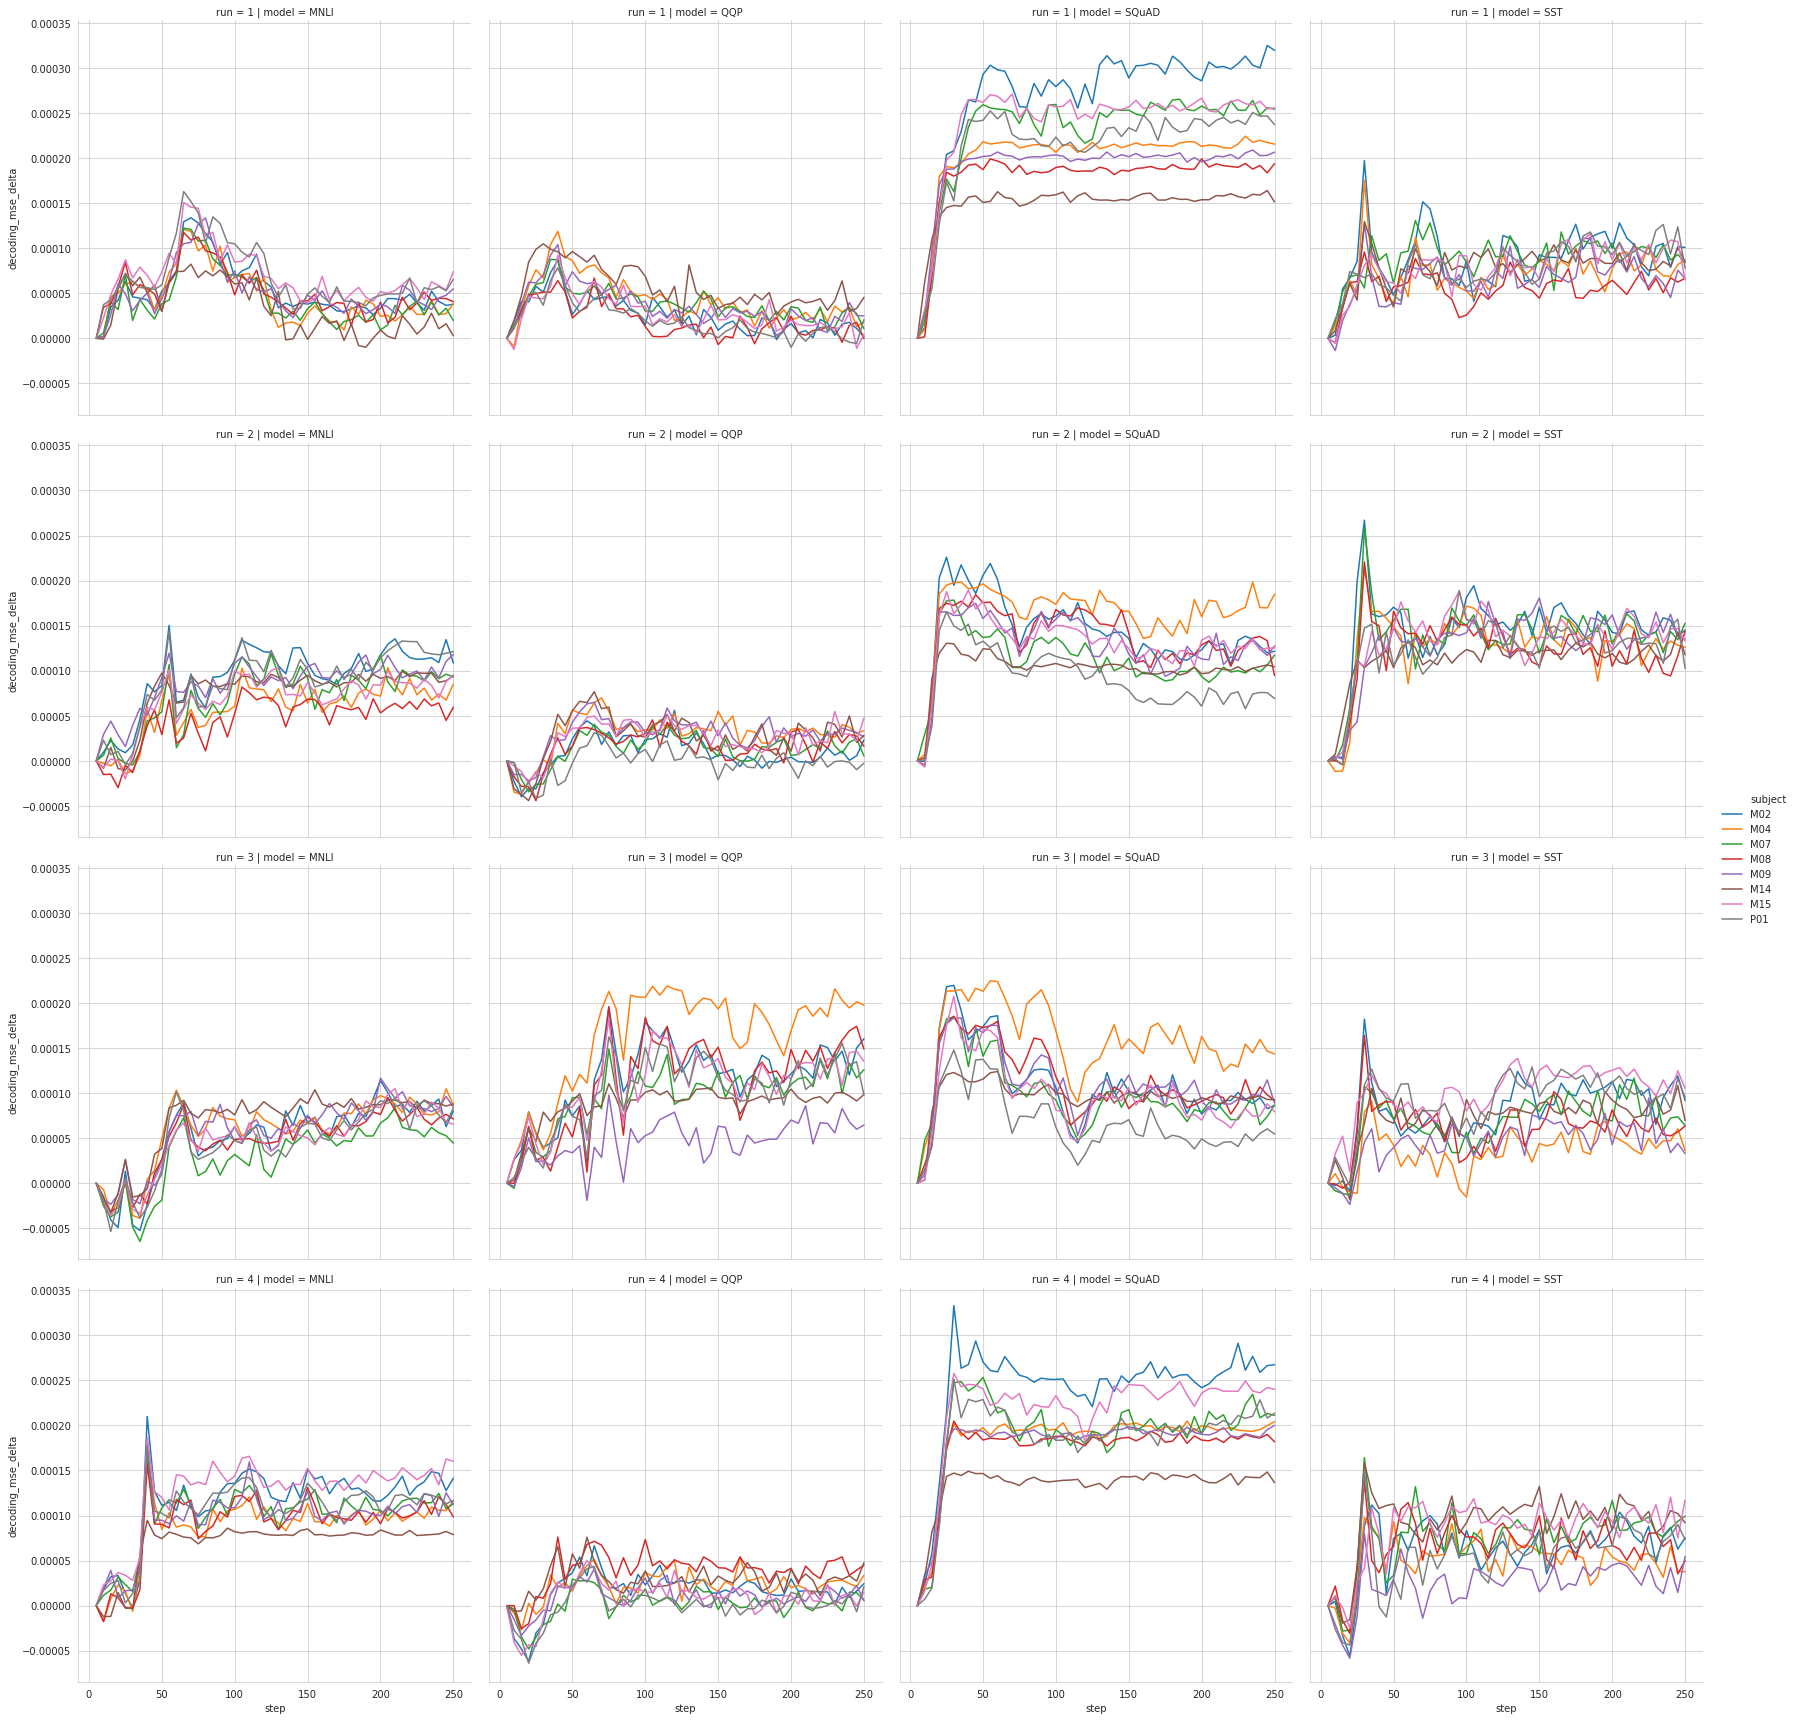

In [19]:
g = sns.FacetGrid(dfi, col="model", row="run", size=6)
g.map(sns.lineplot, "step", "decoding_mse_delta", "subject").add_legend()

### Gradient norm analysis

Text(0,0.5,'$\\Delta$(MSE)')

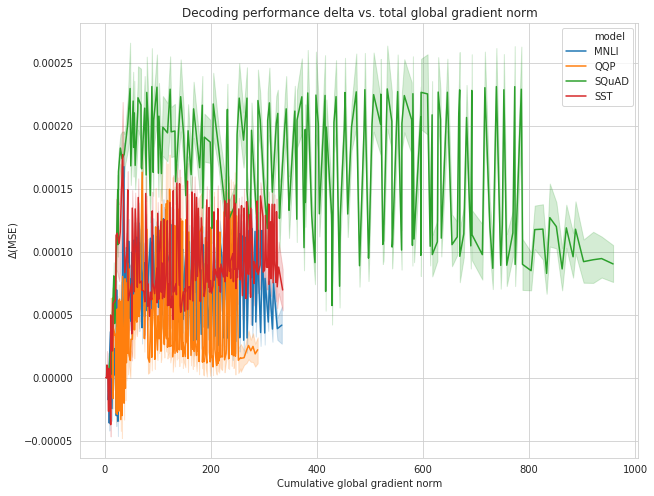

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=dfi, y="decoding_mse_delta", x="total_global_norms", hue="model", ax=ax)
ax.set_title("Decoding performance delta vs. total global gradient norm")
ax.set_xlabel("Cumulative global gradient norm")
ax.set_ylabel(MSE_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


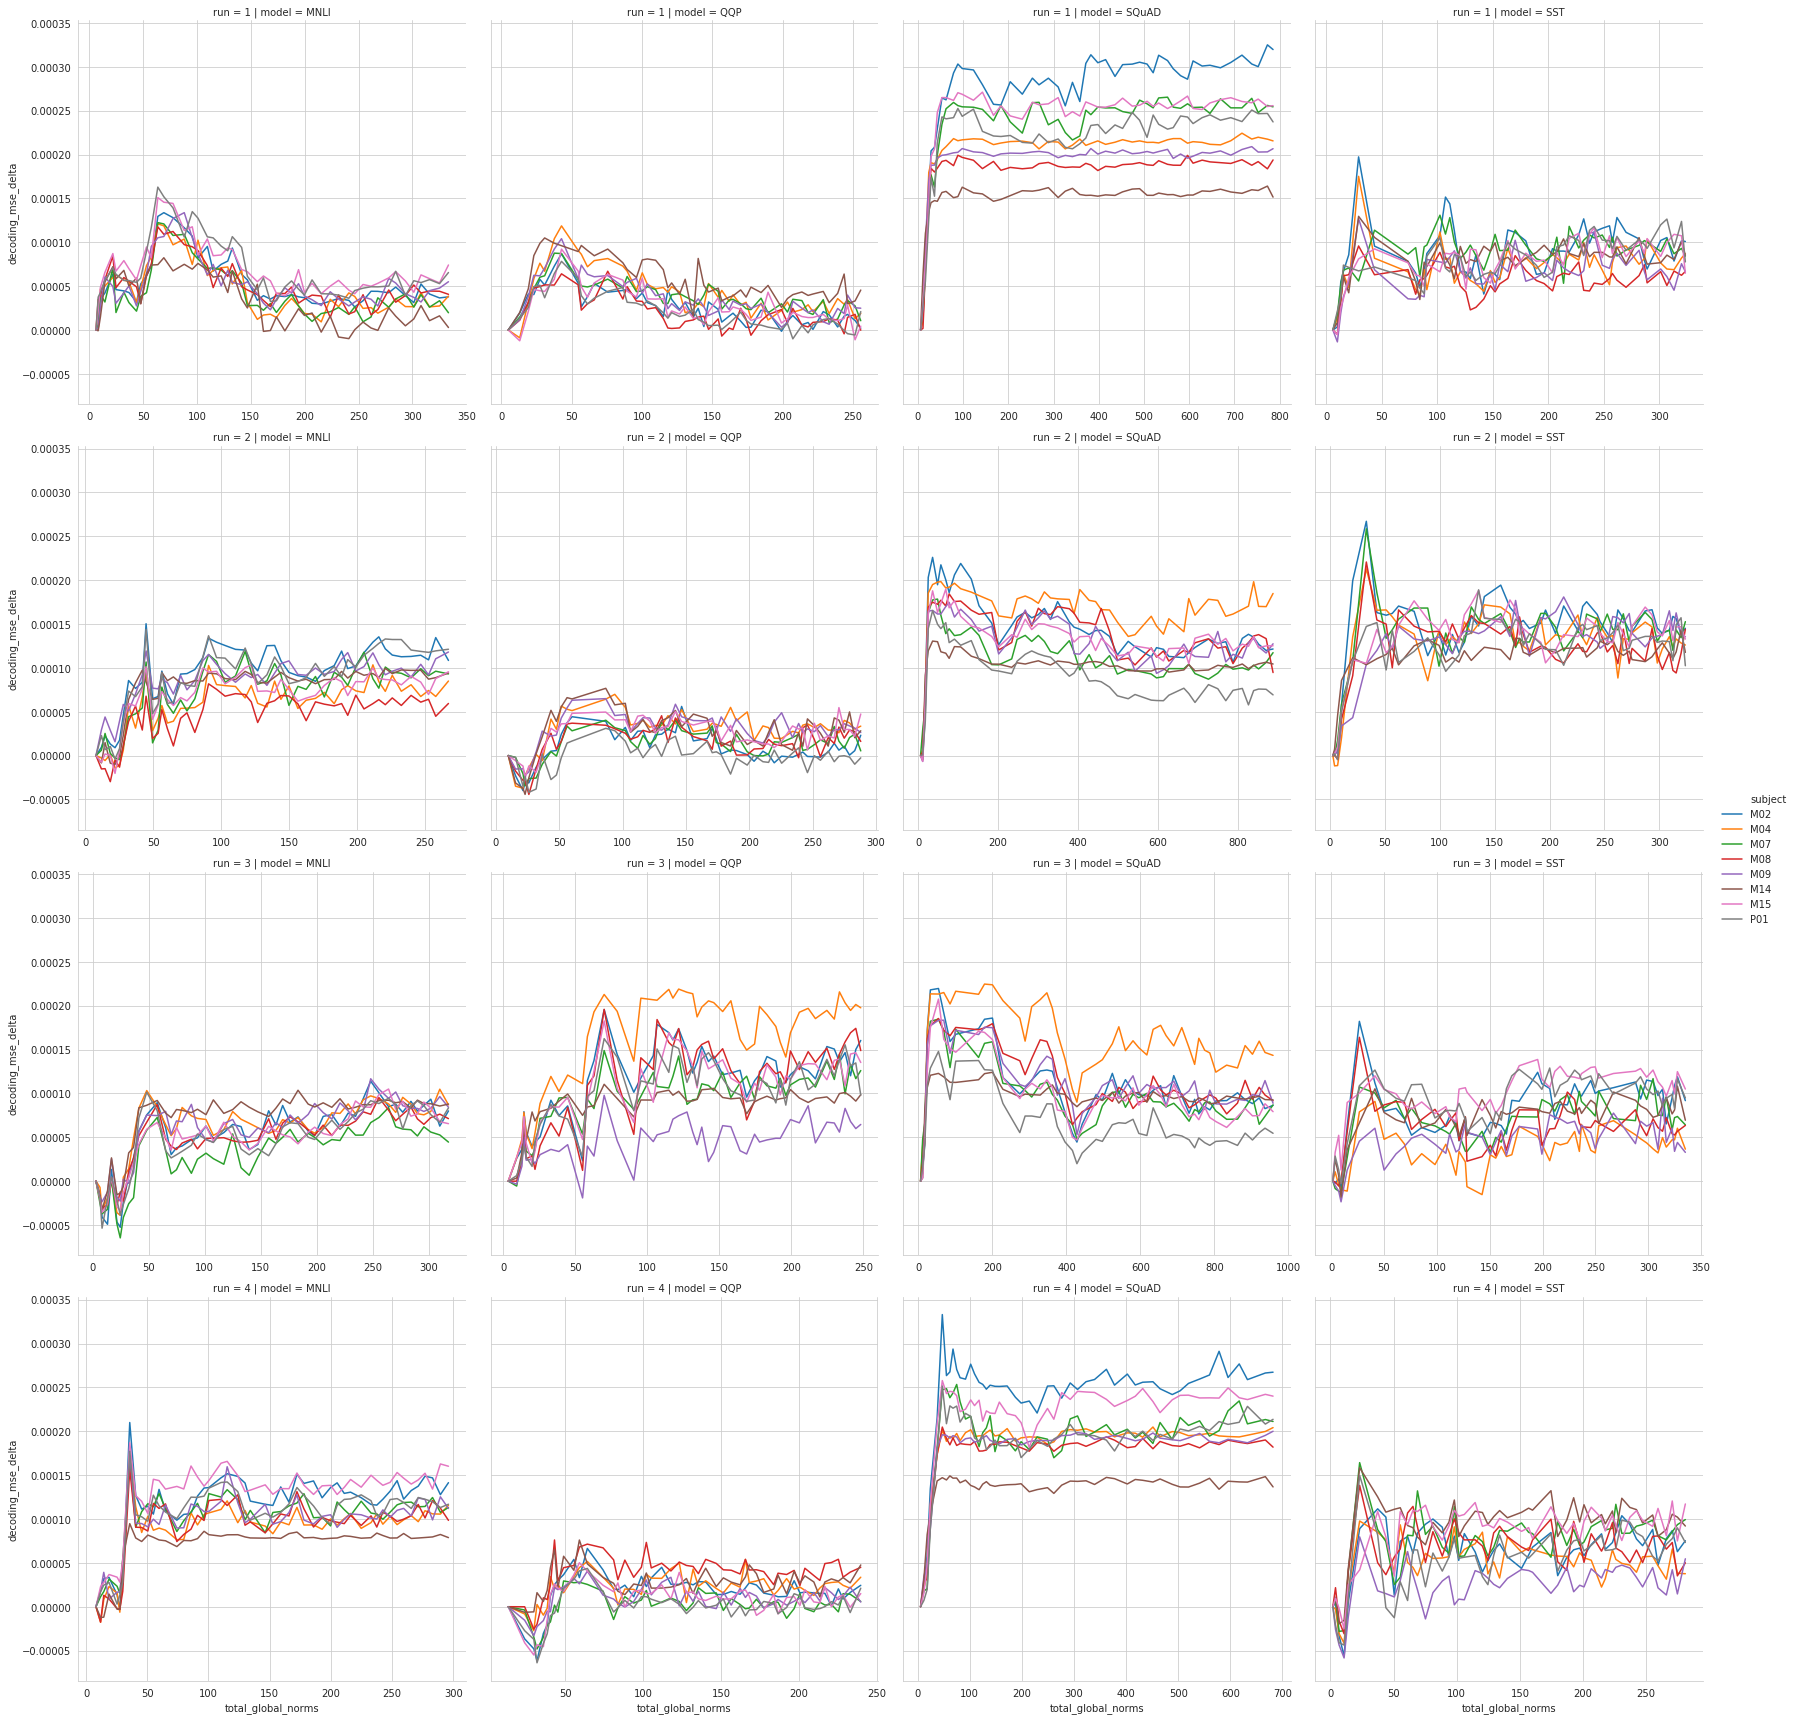

In [21]:
g = sns.FacetGrid(dfi, col="model", row="run", size=6, sharex=False, sharey=True)
g.map(sns.lineplot, "total_global_norms", "decoding_mse_delta", "subject").add_legend()

### Eval accuracy analysis

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


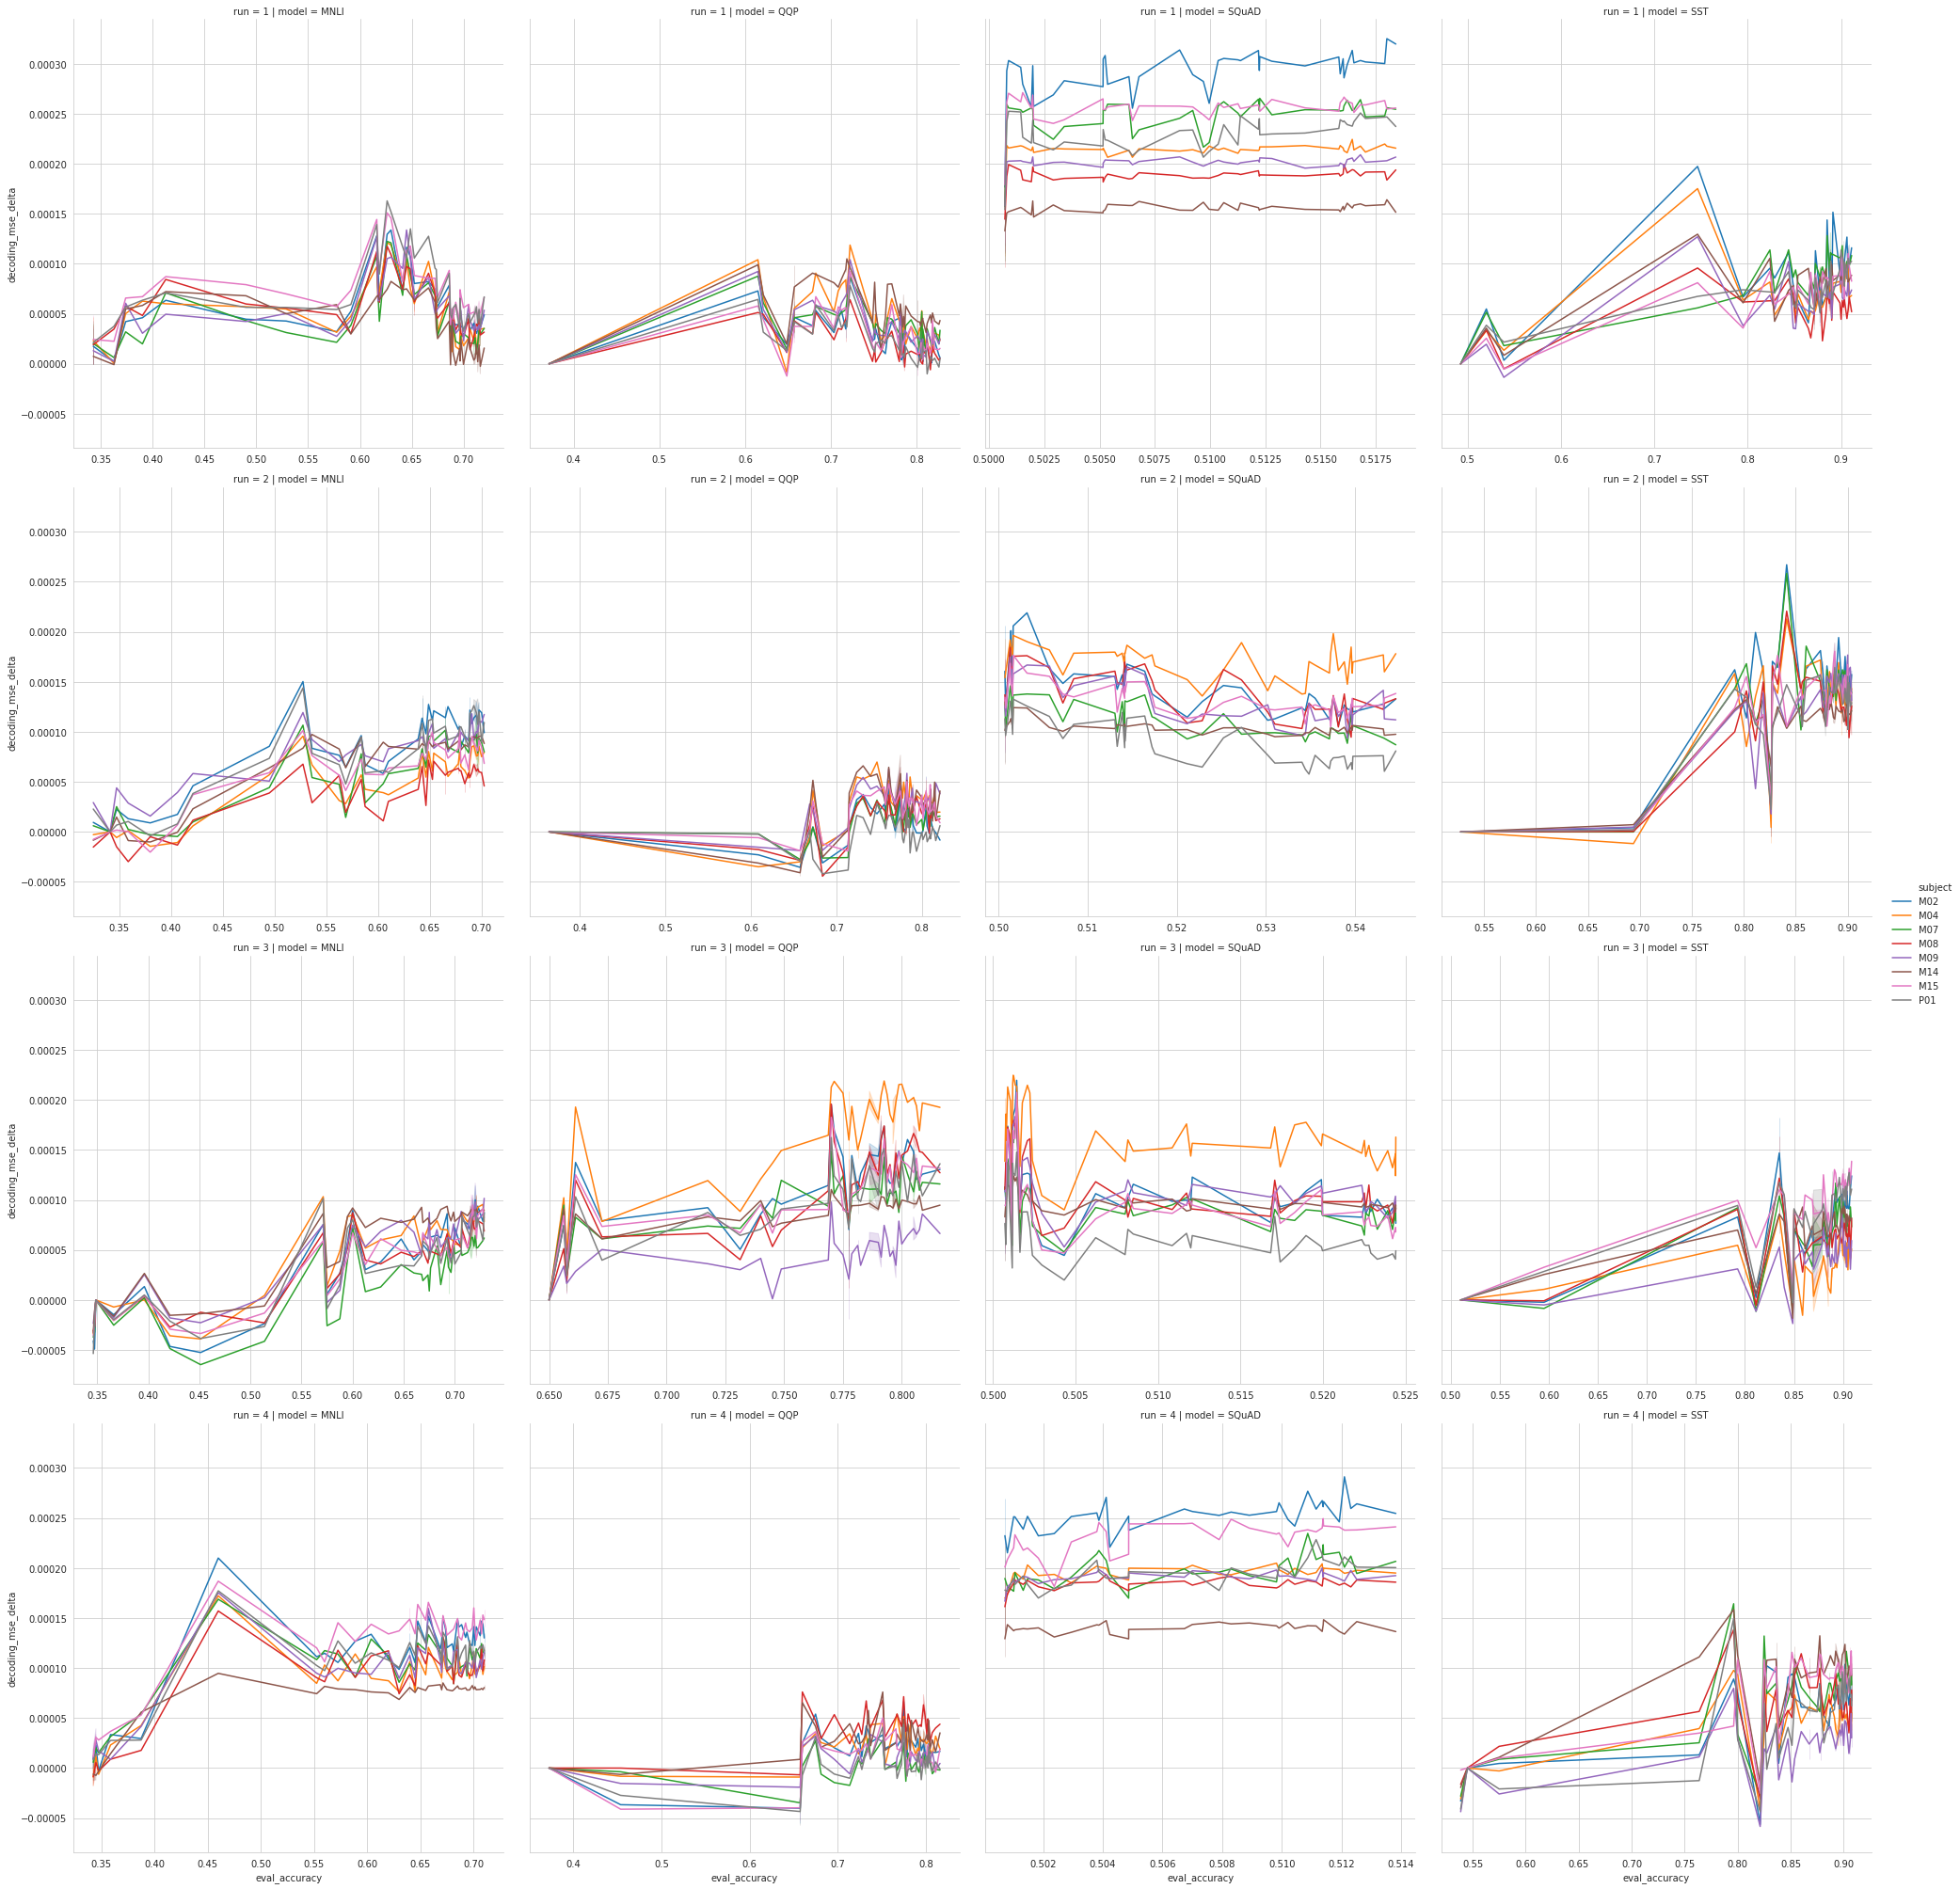

In [22]:
g = sns.FacetGrid(dfi, col="model", row="run", sharex=False, sharey=True, size=7)
g.map(sns.lineplot, "eval_accuracy", "decoding_mse_delta", "subject").add_legend()

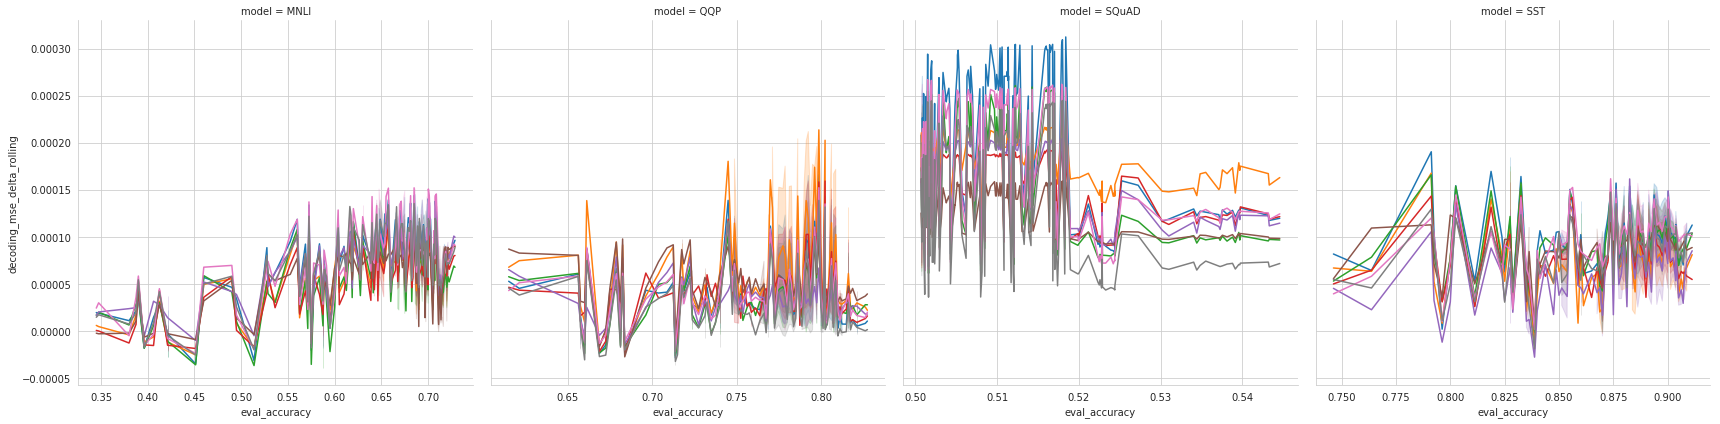

In [23]:
g = sns.FacetGrid(dfi, col="model", height=6, sharex=False, sharey=True)
g.map(sns.lineplot, "eval_accuracy", "decoding_mse_delta_rolling", "subject")

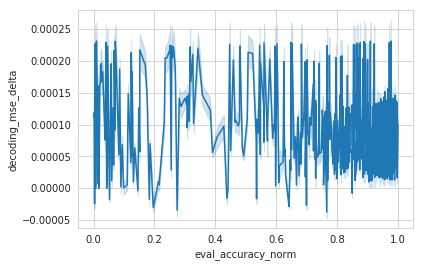

In [24]:
sns.lineplot(data=dfi, x="eval_accuracy_norm", y="decoding_mse_delta")

## Per-subject analysis

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


KeyError: 'subject'

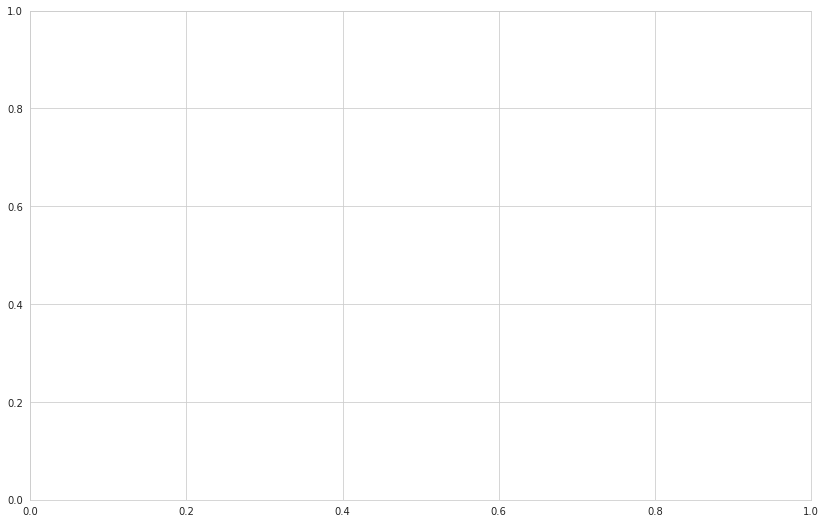

In [25]:
f, ax = plt.subplots(figsize=(14, 9))
dff = dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.mean()).reset_index().melt(id_vars=["model", "run", "subject"], value_name="average decoding_mse_delta")
sns.barplot(data=dff, x="model", hue="subject", y="average decoding_mse_delta", ax=ax)
plt.title("subject average decoding mse delta, averaging across runs")

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.max()).reset_index().melt(id_vars=["model", "run", "subject"], value_name="max decoding_mse_delta")
sns.barplot(data=dff, x="model", hue="subject", y="max decoding_mse_delta", ax=ax)
plt.title("subject max decoding mse delta, averaging across runs")

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.mean()).reset_index().melt(id_vars=["model", "run", "subject"], value_name="average decoding_mse_delta")
sns.barplot(data=dff, x="subject", y="average decoding_mse_delta", ax=ax)
sns.stripplot(data=dff, x="subject", y="average decoding_mse_delta", edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject average decoding mse delta, averaging across models and runs")

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.max()).reset_index().melt(id_vars=["model", "run", "subject"], value_name="max decoding_mse_delta")
sns.barplot(data=dff, x="subject", y="max decoding_mse_delta", ax=ax)
sns.stripplot(data=dff, x="subject", y="max decoding_mse_delta", edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject max decoding mse delta, averaging across models and runs")